In [1]:
import os
# Changing the working directory
os.chdir('../..')
os.getcwd()

'/home/javiermunoz/Universidad/MasterBDyDS/TFM/TFM_DSBD'

In [2]:
import tensorflow as tf
import keras
from keras import layers
import pathlib

from src.frame_generator import FrameGenerator
from blocks import Conv2Plus1D, ResizeVideo, add_residual_block
from src.config import DATA_PATH, SPLITS
from src.plot_utils import plot_history
import numpy as np

2023-04-30 17:16:26.067437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 17:16:26.206790: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-30 17:16:26.713235: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2023-04-30 17:16:26.713309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dle

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

2023-04-30 17:16:27.924677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:16:27.956206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:16:27.956436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [5]:
subset_size = 10
subset = f"subset_{subset_size}_lsa_64"
model_type = "3DCNN"
model_name = "3dcnn"

In [6]:
subset_paths = {}
for sp in SPLITS:
    subset_paths[sp] = pathlib.Path(os.path.join(DATA_PATH, subset, sp))

In [7]:
n_frames = 10
batch_size = 16

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

2023-04-30 17:16:28.075299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 17:16:28.076574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:16:28.076866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-30 17:16:28.077077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [9]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [10]:
frames, label = next(iter(train_ds))
model.build(frames)

2023-04-30 17:16:42.792772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 1000
2023-04-30 17:16:50.793620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 1000
2023-04-30 17:17:02.710512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 8 of 1000
2023-04-30 17:17:11.959283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 10 of 1000
2023-04-30 17:17:23.695763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 13 of 1000
2023-04-30 17:17:31.406025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15 of 1000
2023-04-30 17:17:42.993821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (th

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 224, 22  0           []                               
                                4, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 10, 224, 224  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 224, 224  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

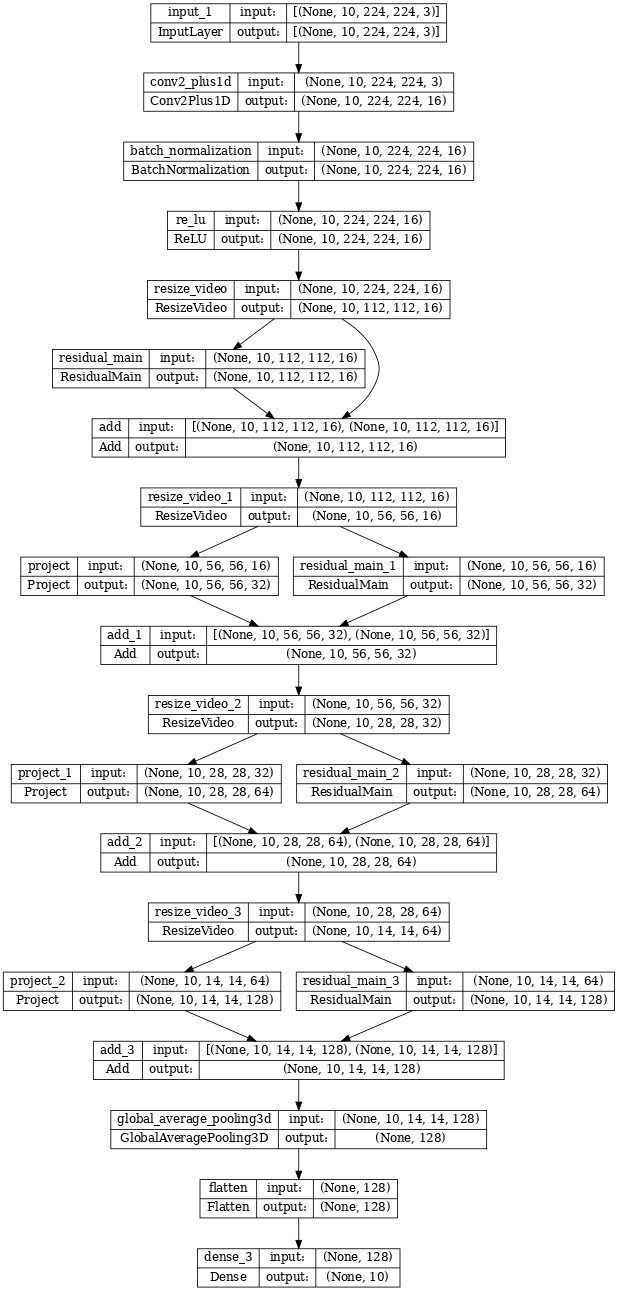

In [12]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [13]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [14]:
# CReate a customized callback so when val_acc > 94% it stops training
from keras.callbacks import EarlyStopping, ModelCheckpoint

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

bst_model_path = "src/"+model_type+"/bestmodels/best_"+model_name+"_{epoch:02d}_{val_accuracy:.2f}"+subset_size+"_model.h5"

callbacks = [
    EarlyStopping(monitor="loss", patience=15),
    EarlyStopping(monitor="accuracy", patience=15),
    ModelCheckpoint(filepath=bst_model_path, save_best_only=True, save_weights_only=True, monitor="val_accuracy", mode='max'),
    MyThresholdCallback(threshold=0.94)
    
]


In [21]:
history = model.fit(train_ds,
                    epochs=120, 
                    validation_data=val_ds,
                    callbacks=callbacks,
                    batch_size=batch_size)

Epoch 1/120
      6/Unknown - 5s 765ms/step - loss: 1.0225 - accuracy: 0.5833WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3345s vs `on_train_batch_end` time: 0.4305s). Check your callbacks.
25/25 [==============================] - 20s 785ms/step - loss: 0.9732 - accuracy: 0.6269 - val_loss: 1.5161 - val_accuracy: 0.4167
Epoch 2/120
25/25 [==============================] - 19s 762ms/step - loss: 0.9597 - accuracy: 0.6802 - val_loss: 1.6157 - val_accuracy: 0.5000
Epoch 3/120
25/25 [==============================] - 19s 763ms/step - loss: 0.9423 - accuracy: 0.6472 - val_loss: 1.0949 - val_accuracy: 0.5333
Epoch 4/120
25/25 [==============================] - 19s 763ms/step - loss: 0.9337 - accuracy: 0.6751 - val_loss: 1.4073 - val_accuracy: 0.4833
Epoch 5/120
25/25 [==============================] - 19s 763ms/step - loss: 0.9050 - accuracy: 0.6675 - val_loss: 1.0822 - val_accuracy: 0.6167
Epoch 6/120
25/25 [======================

In [22]:
best_model_epoch = np.argmax(history.history['val_accuracy'])
best_acc, best_loss, best_val_acc, best_val_loss = history.history['accuracy'][best_model_epoch], history.history['loss'][best_model_epoch], history.history['val_accuracy'][best_model_epoch], history.history['val_loss'][best_model_epoch]

In [23]:
#best_model = tf.keras.models.load_model(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_model.h5")

model.load_weights(f"src/{model_type}/bestmodels/best_{model_name}_{(best_model_epoch+1):02d}_{best_val_acc:.2f}_{subset_size}_model.h5")

In [24]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
test_results = model.evaluate(test_ds, batch_size=batch_size)
print("test loss, test acc:", test_results)

Evaluate on test data
3/3 [==============================] - 12s 4s/step - loss: 0.4247 - accuracy: 0.8696
test loss, test acc: [0.4247016906738281, 0.8695651888847351]


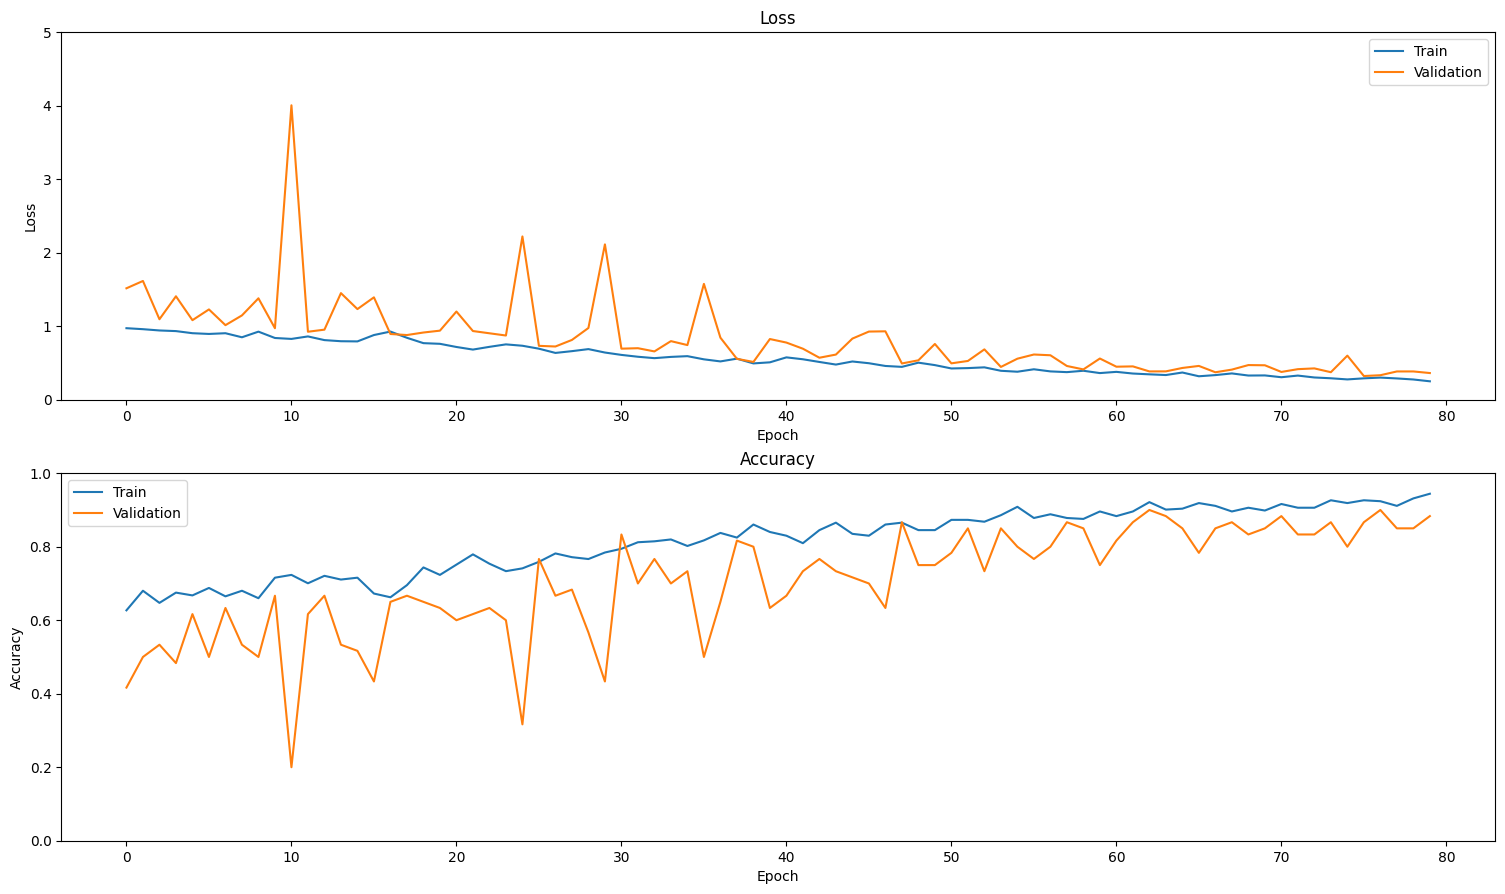

In [25]:
plot_history(history)

In [26]:
from src.leaderboard import Leaderboard

lb = Leaderboard()
lb.update_leaderboard(history=history,
                      test_results=test_results,
                      model_name=model_name,
                      model_type=model_type,
                      subset_size=subset_size)

lb.lb

,model_type,model_name,train_acc,val_acc,test_acc,train_loss,val_loss,test_loss,epoch,path_to_model,subset_size
0,mediapipe,mp,0.95,0.92,0.93,0.22,0.28,0.28,77.0,src/mediapipe/bestmodels/best_mp_77_0.92_model.h5,10.0
1,convlstm,simple,0.96,0.93,0.93,0.15,0.20,0.19,39.0,src/convlstm/bestmodels/best_simple_39_0.93_mo...,10.0
2,convlstm,stateless,0.93,0.95,0.91,0.22,0.19,0.19,22.0,src/convlstm/bestmodels/best_stateless_22_0.95...,10.0
3,3DCNN,3dcnn,0.92,0.90,0.87,0.35,0.39,0.42,63.0,src/3DCNN/bestmodels/best_3dcnn_63_0.90_model.h5,10.0
